# CSE151A - PA3
By: Jonathan Lo<br>
Date: 7/27/23

## Overhead

In [1]:
# Imports
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Dataset loading
toy = pd.read_csv("data3.txt", delimiter=" ", header=None)
toy.rename(columns={0: "x1", 1: "x2", 2: "y"}, inplace=True)
ccf = pd.read_csv("creditcard.csv")
heart = pd.read_csv("../pa2/heart.csv")

# Ignore warnings
warnings.filterwarnings("ignore")

## Questions

### Q1a

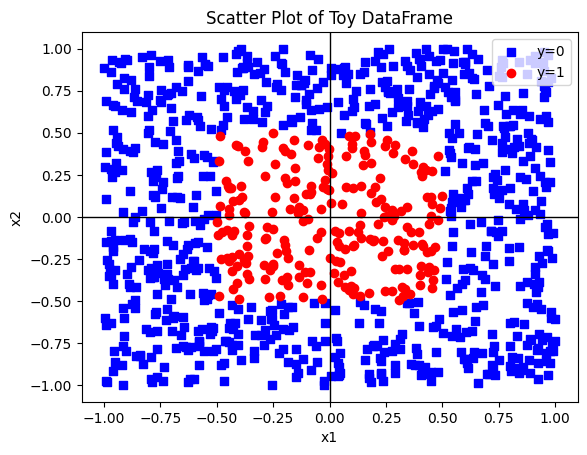

In [3]:
# Sep df
df_0 = toy[toy['y'] == 0]
df_1 = toy[toy['y'] == 1]

# Plot
plt.scatter(df_0['x1'], df_0['x2'], c='blue', marker='s', label='y=0')
plt.scatter(df_1['x1'], df_1['x2'], c='red', marker='o', label='y=1')
plt.axhline(0, color='black', linewidth=1) 
plt.axvline(0, color='black', linewidth=1) 
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter Plot of Toy DataFrame')
plt.legend(loc="upper right")
plt.show()

### Q1b

In [4]:
# Init model
clf = DecisionTreeClassifier(random_state=0, criterion="entropy", max_depth=5)

# Fit
X = toy[['x1', 'x2']]
y = toy['y']
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)

Stopping criteria is set `max_depth` which is set to 5.

### Q1c

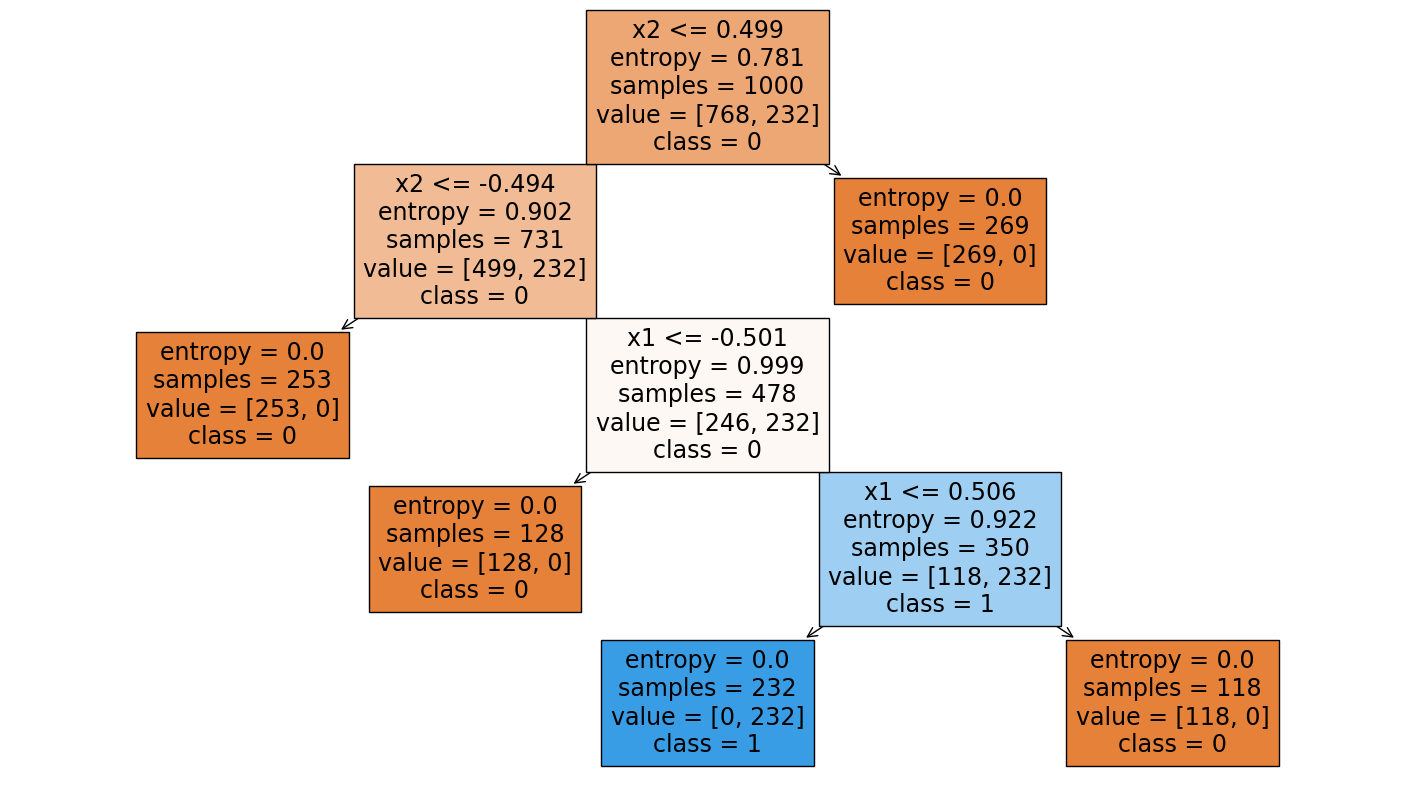

In [5]:
# Plot
plt.figure(figsize=(18, 10))
plot_tree(clf, feature_names=['x1', 'x2'], class_names=['0', '1'], filled=True)
plt.show()

### Q1d

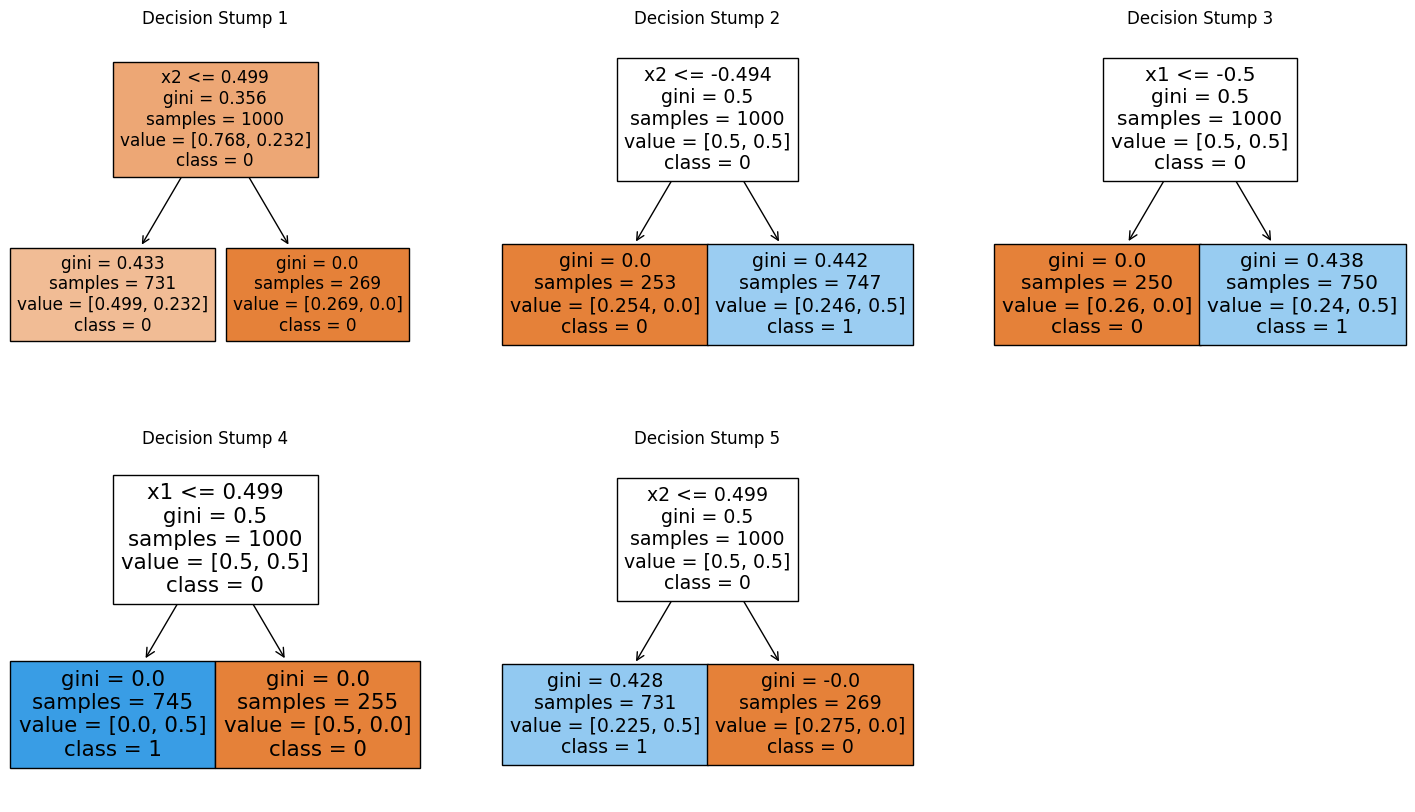

In [6]:
# Init model
model = AdaBoostClassifier(random_state=0, n_estimators=5)

# Fit
model.fit(X, y)

# Plot all the decision stumps
plt.figure(figsize=(18, 10))
for i, estimator in enumerate(model.estimators_):
    plt.subplot(2, 3, i+1)
    plot_tree(estimator, feature_names=['x1', 'x2'], class_names=['0', '1'], filled=True)
    plt.title(f'Decision Stump {i+1}')
plt.show()

### Q1e

In [7]:
# Get accuracies for each stump
accuracy_table = pd.DataFrame(columns=['Stump Number', 'Accuracy'])
for i, y_pred in enumerate(model.staged_predict(X)):
    accuracy = accuracy_score(y, y_pred)
    accuracy_table = accuracy_table.append({'Stump Number': i+1, 'Accuracy': accuracy}, ignore_index=True)
display(accuracy_table)

,Stump Number,Accuracy
0,1.0,0.768
1,2.0,0.768
2,3.0,0.882
3,4.0,1.000
4,5.0,1.000


### Q2a

In [8]:
# Get counts
ccf.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

There are only **492** total fradulent classifiers. This may be problematic when training a classifier becuase the non-fradulent cases are overrepresented which can cause the model to be overbiased. For example, a model that predicts only fradulent would still have an error rate of < 0.005.

### Q2b

In [9]:
# Get 500 rows of class 0
class0_f500 = ccf[ccf.Class == 0][:500]
class1 = ccf[ccf.Class == 1]

# Merge with class 1
ccf = pd.concat([class0_f500, class1])
ccf = ccf.reset_index().drop(columns=["index"])

# Define vars
X = ccf.drop('Class', axis=1)
y = ccf['Class']

# Init models
dtc = DecisionTreeClassifier(random_state=0)
abc = AdaBoostClassifier(random_state=0)

# Use 10-fold
predicted_dtc = cross_val_predict(dtc, X, y, cv=10)
predicted_abc = cross_val_predict(abc, X, y, cv=10)

# Calc confusion matricies
conf_matrix_dtc = confusion_matrix(y, predicted_dtc)
conf_matrix_abc = confusion_matrix(y, predicted_abc)

print("DecisionTreeClassifier Confusion Matrix:")
print(conf_matrix_dtc)
print("\nAdaBoostClassifier Confusion Matrix:")
print(conf_matrix_abc)

DecisionTreeClassifier Confusion Matrix:
[[498   2]
 [ 25 467]]

AdaBoostClassifier Confusion Matrix:
[[498   2]
 [ 25 467]]


### Q3

In [10]:
# Split data
X = heart.iloc[:, :-1] 
y = heart.iloc[:, -1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Init and fit model
logreg = LogisticRegression(max_iter=1000, C=0.0001)
logreg.fit(X_train, y_train)

# Pred
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)

# Get log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print("Log Loss:", log_loss_value)

Log Loss: 0.571044589440542


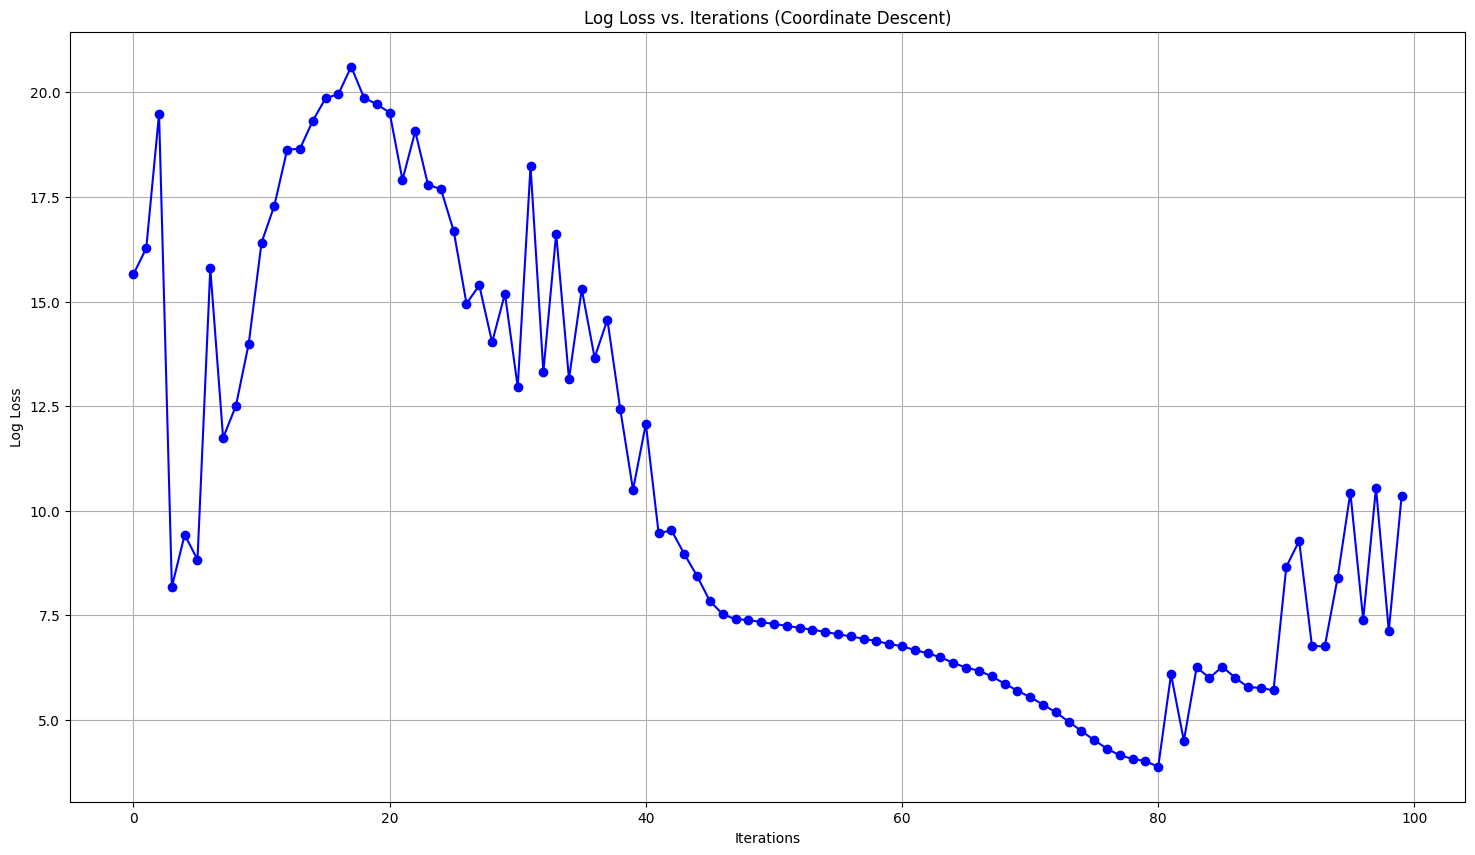

In [11]:
# log func
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Coordinate descent for logistic regression
def coordinate_descent(X, y, max_iterations=100, learning_rate=0.01):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    loss_values = []

    for t in range(max_iterations):
        prev_w = np.copy(w)
        for i in range(n_features):
            w_i = np.dot(X[:, i], y - sigmoid(np.dot(X, w))) / n_samples
            w[i] = w[i] + learning_rate * w_i

        # Calculate log loss
        y_pred_prob = sigmoid(np.dot(X_test, w))
        loss_value = log_loss(y_test, y_pred_prob)
        loss_values.append(loss_value)

        # Check for convergence 
        if t > 0 and np.linalg.norm(w - prev_w) < 1e-6:
            break

    return w, loss_values

# Get weights and losses
optimal_weights, loss_values = coordinate_descent(X_train.values, y_train.values)

# Plot 
iterations = range(len(loss_values))
plt.figure(figsize=(18,10))
plt.plot(iterations, loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. Iterations (Coordinate Descent)')
plt.grid(True)
plt.show()